In [1]:
# various import statements
import os
import inspect
import seaborn
import matplotlib
import matplotlib.pyplot as plt
import torch
import scanpy as sc
import pyro
import cuml

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print("GPU is available")
    print("Number of GPUs:", torch.cuda.device_count())
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("GPU is not available")
    
import random

import sys
import antipode
from antipode.antipode_model import *
import antipode.model_functions
from antipode.model_functions import *
import antipode.model_distributions
from antipode.model_distributions import *
import antipode.model_modules
from antipode.model_modules import *
import antipode.train_utils
from antipode.train_utils import *
import antipode.plotting
from antipode.plotting import *
from antipode.antipode_mixins import AntipodeTrainingMixin, AntipodeSaveLoadMixin


/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPU is available
Number of GPUs: 1
GPU Name: NVIDIA A100-PCIE-40GB


In [2]:
model_tag='1.9.1.8.5_Dev_final_noQ_INP'
out_path=os.path.join('/home/matthew.schmitz/Matthew/models/',model_tag)
batch_key='batch_name'
discov_key='species'
layer_key='spliced'


In [ ]:
# adata = antipode.anndata_utils.read_h5ad_backed_selective(os.path.expanduser('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/HvQvM/HvQvMall_cere_clean_nodoublets.h5ad'),
#     mode='r', selected_keys=['S_score','G2M_score','phase','log10_n_counts','region', batch_key,discov_key,layer_key, 'var', 'uns'])

# adata.obs['female']=adata.obs['batch_name'].replace(pd.read_csv('/home/matthew.schmitz/Matthew/data/taxtest/extra/inferred_sex.csv',index_col=0).to_dict()['female'])
# adata.obsm['phase_sex']=np.concatenate([adata.obs['S_score'].to_numpy().reshape(-1,1),adata.obs['G2M_score'].to_numpy().reshape(-1,1),adata.obs['log10_n_counts'].to_numpy().reshape(-1,1),antipode.model_functions.numpy_onehot(adata.obs['female'].cat.codes)],axis=1)
# adata.obsm['phase_sex']=adata.obsm['phase_sex']/np.abs(adata.obsm['phase_sex']).max(0)#Scale so max value is magnitude 1

# species_aggr_means=antipode.model_functions.group_aggr_anndata(adata,[discov_key],layer='spliced',normalize=True)
# species_real_means=torch.tensor(species_aggr_means[0],requires_grad=False)
# species_log_real_means=safe_log_transform(species_aggr_means[0]) # #species,#cluster,#genes array


In [26]:
del adata.uns['hvg']

In [33]:
del adata.uns['neighbors']

In [ ]:
adata

In [ ]:
# num_var=adata.shape[1]
# batch_size=32
# level_sizes=[1,50,300]
# num_latent=200
# steps=0
# max_steps=1500000
# num_particles=4
# print_every=5000

# # Clear Pyro param store so we don't conflict with previous run
# try:
#     pyro.clear_param_store()
#     del antipode_model
#     torch.cuda.empty_cache()
# except:
#     pass
# # Fix random number seed to a lucky number
# pyro.util.set_rng_seed(13)
# # Enable optional validation warnings
# pyro.enable_validation(False)

# # Instantiate instance of model/guide and various neural networks
# antipode_model = ANTIPODE(num_latent=num_latent,level_sizes=level_sizes,seccov_key='phase_sex',bi_depth=2,num_batch_embed=10,psi_levels=[0.,1.,1.],
#                 adata=adata,discov_pair=('obs',discov_key),batch_pair=('obs',batch_key),layer=layer_key,min_theta=1e-1,
#                 use_psi=True,use_q_score=False,prior_scale=50.,theta_prior=10,sampler_category='species',dist_normalize=False,dcd_prior=torch.tensor(species_log_real_means,requires_grad=False).float(),
#                 scale_init_val=0.01,loc_as_param=False,zdw_as_param=False,intercept_as_param=False,seccov_as_param=False)

In [ ]:
# antipode_model.run_standard_protocol(out_path,
#                                      max_steps=max_steps,
#                                      num_particles=num_particles,
#                                      device=device,
#                                      max_learning_rate=1e-3,
#                                      one_cycle_lr=True,
#                                      batch_size=batch_size)

In [3]:
adata = sc.read_h5ad(os.path.join('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/models',model_tag,'p4_adata.h5ad'),backed='r')

In [4]:
antipode_model=ANTIPODE.load(os.path.join('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/models',model_tag),adata=adata,prefix='p3_',device=device)
adata=antipode_model.adata_manager.adata
antipode_model.store_outputs(device=device,prefix='')

In [5]:
antipode_model.to(device)
posterior_out,posterior_categories = antipode_model.correct_fits(batch_size=128, n_steps = 100000)
antipode_model.store_outputs(device=device,prefix='')


In [6]:
!nvidia-smi
antipode_model.clear_cuda()
!nvidia-smi

Fri Feb  7 19:44:04 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.57.01              Driver Version: 565.57.01      CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-PCIE-40GB          Off |   00000000:17:00.0 Off |                    0 |
| N/A   40C    P0             36W /  250W |    9351MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [7]:
MDE_KEY = "X_antipode_UMAP"
umap = cuml.UMAP(n_neighbors = 60,min_dist=0.2,spread=1,metric='manhattan',)
adata.obsm[MDE_KEY] = clip_latent_dimensions(umap.fit_transform(adata.obsm['X_antipode']),0.1)

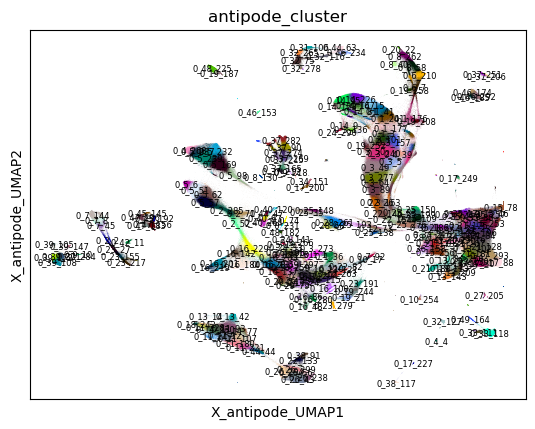

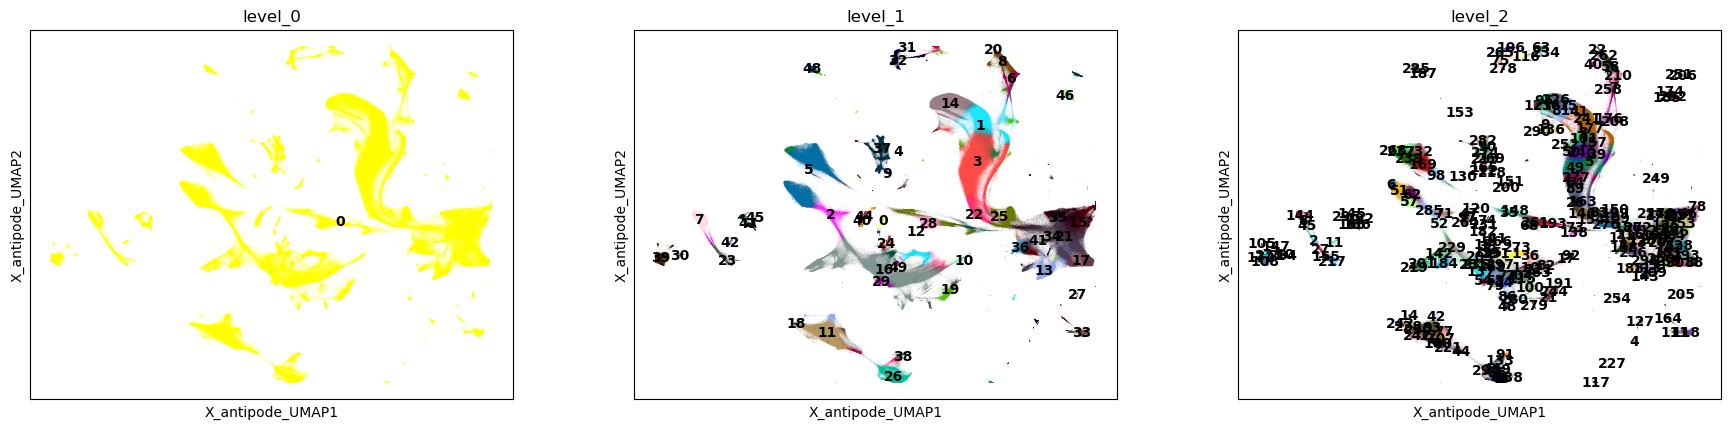

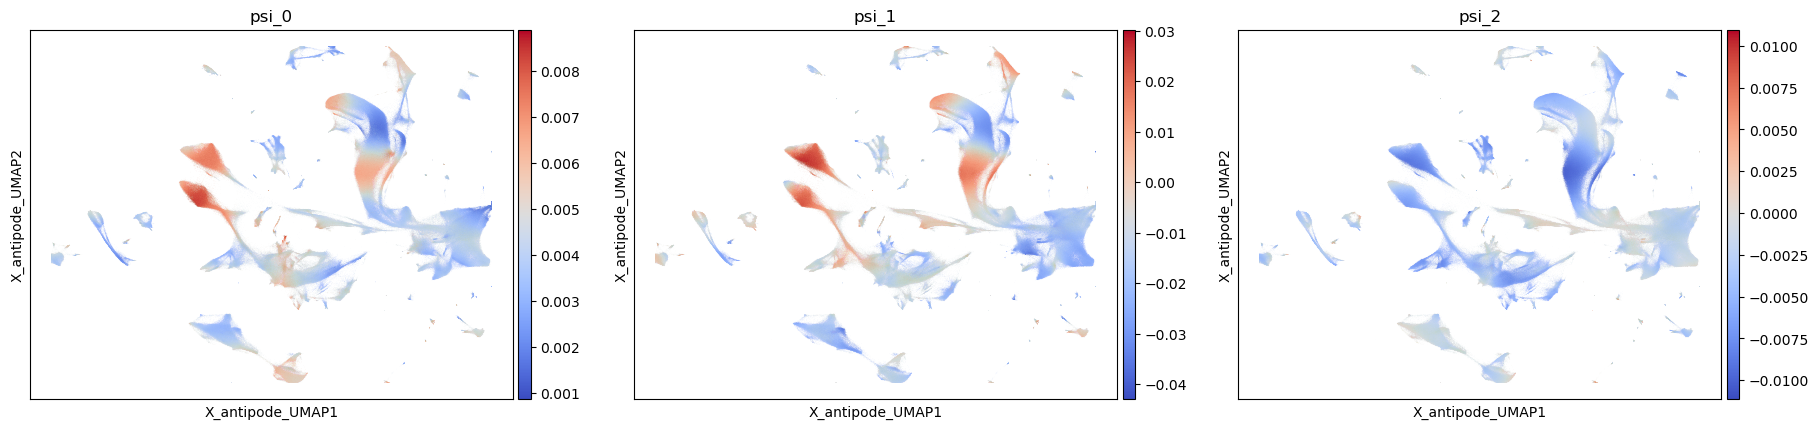

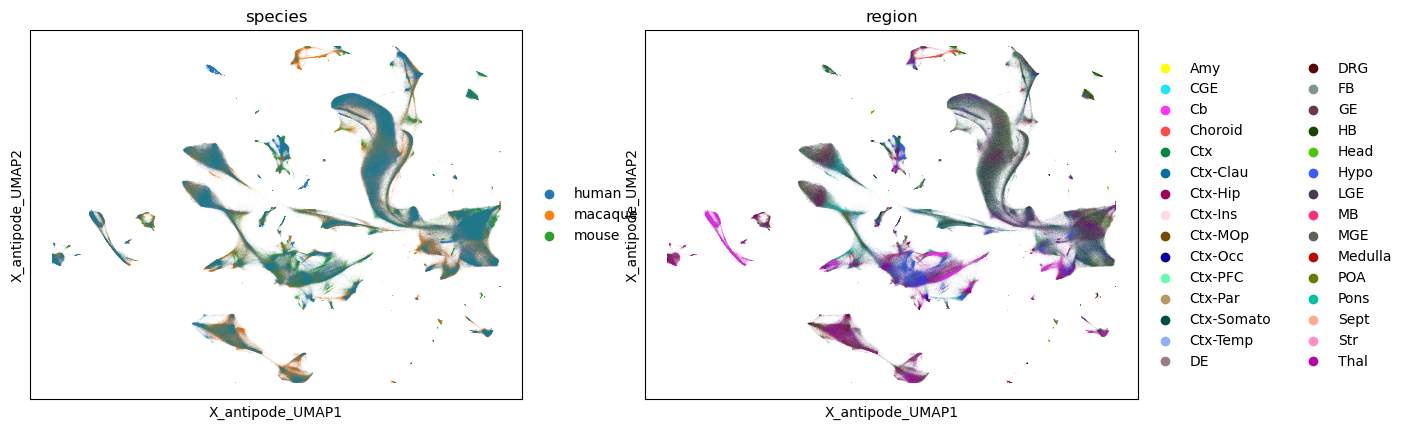

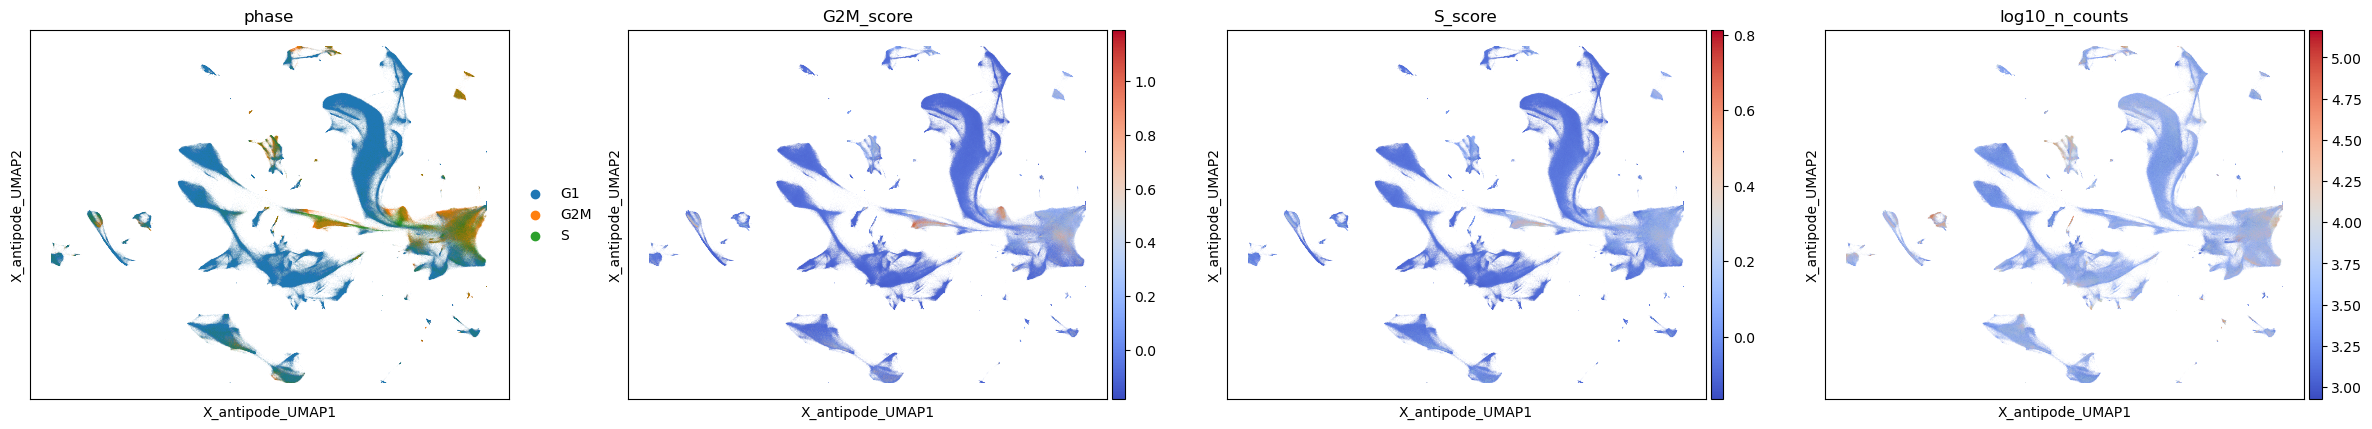

In [8]:
sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=["antipode_cluster"],legend_fontsize=6,legend_fontweight='normal',#,"kmeans"
    legend_loc='on data',palette=sc.pl.palettes.godsnot_102
)

sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=[x for x in adata.obs.columns if 'level' in x],
    palette=sc.pl.palettes.godsnot_102,
    legend_loc='on data'
)

sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=[x for x in adata.obs.columns if 'psi' in x],
    cmap='coolwarm',
    legend_loc='on data'
)

sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=['species','region']
)

sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=['phase','G2M_score','S_score','log10_n_counts'],cmap='coolwarm'
)


/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


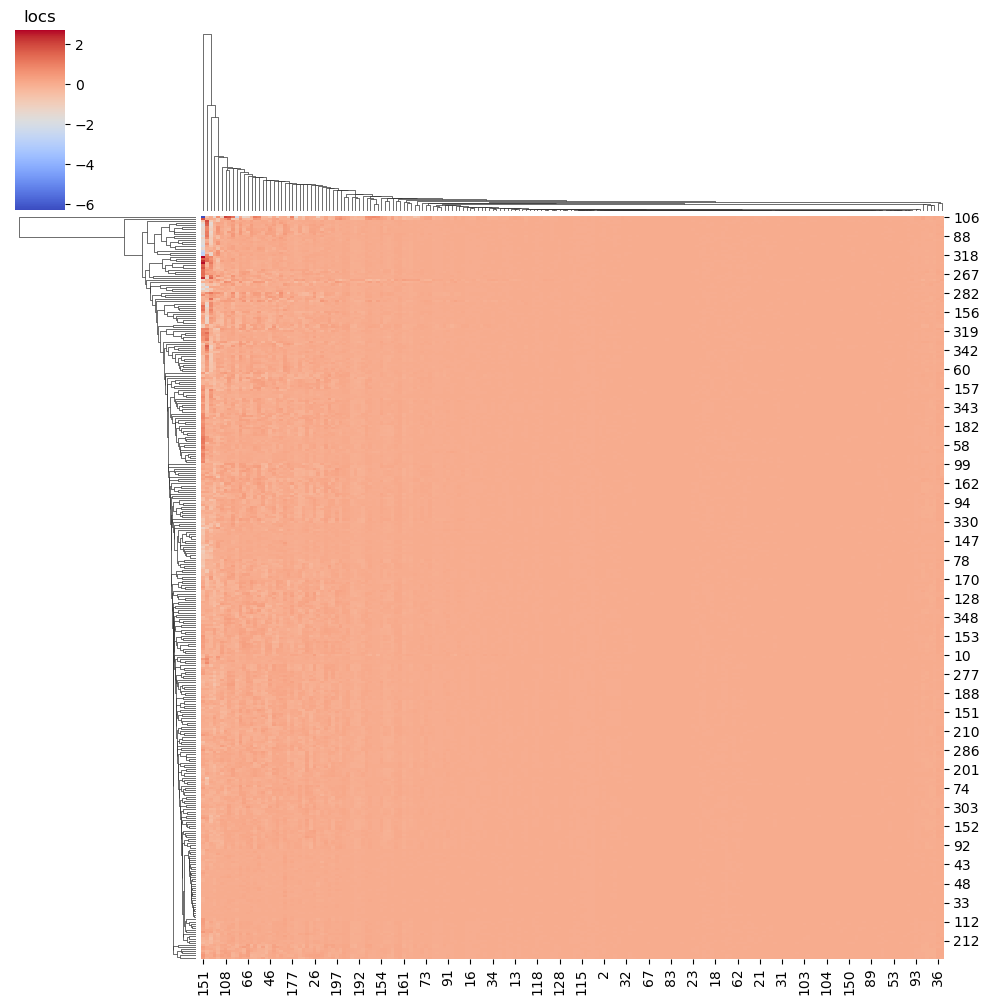

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


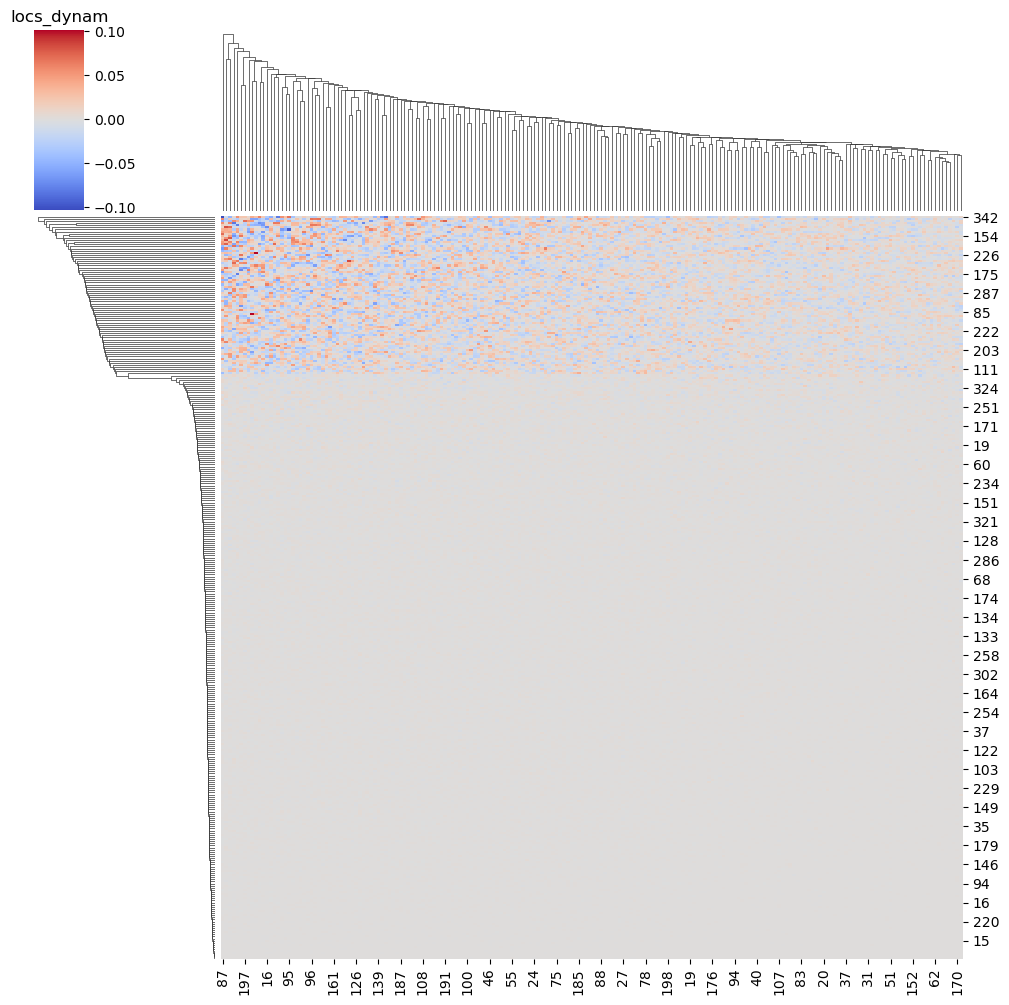

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


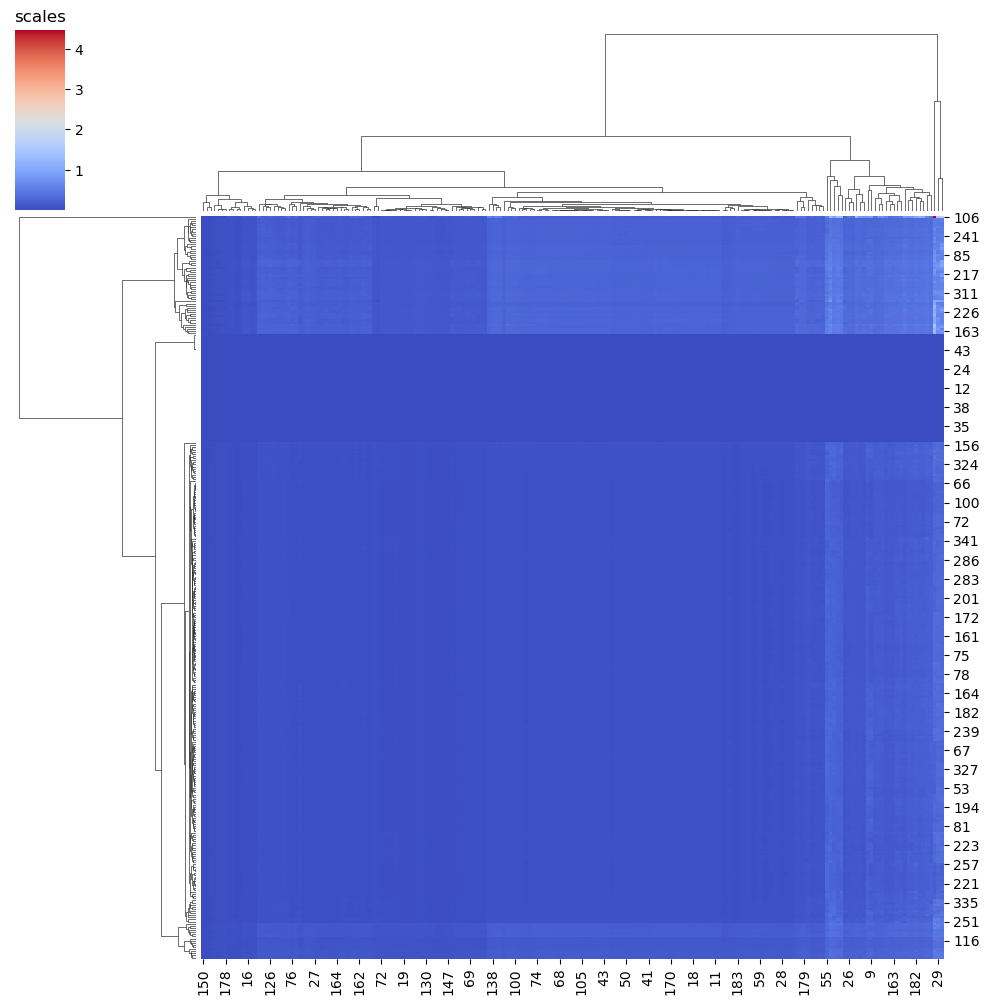

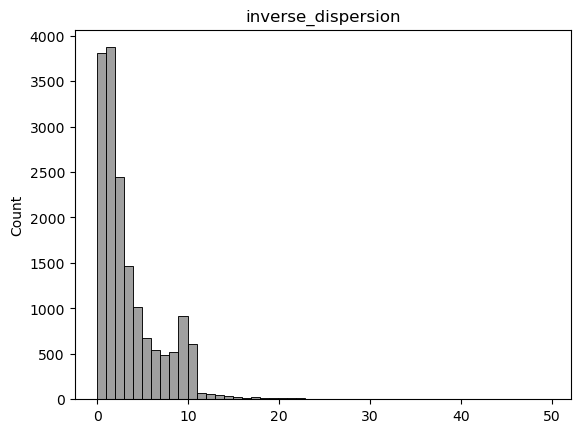

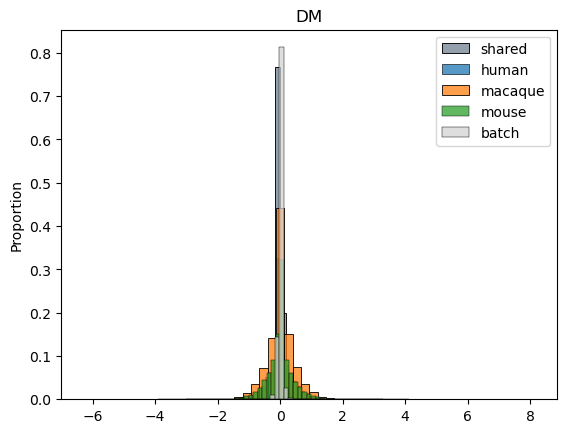

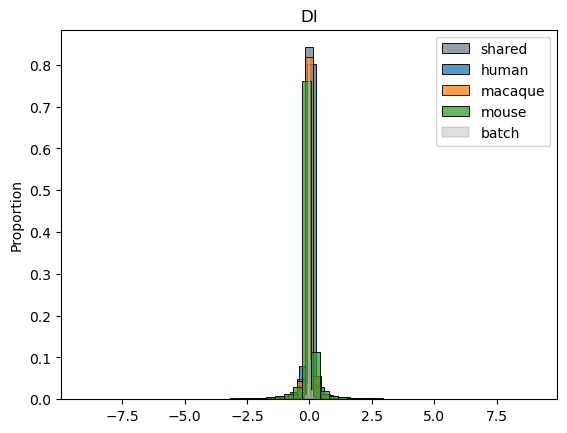

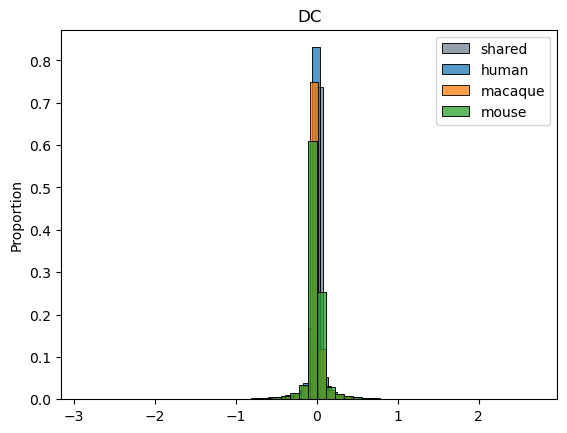

/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/code/scANTIPODE/antipode/plotting.py:77: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_species=antipode_model.adata_manager.adata.obs.groupby(antipode_model.batch_key)['species'].value_counts().unstack().idxmax(axis=1).to_dict()


,0,1,batch_name,species
0,-0.930857,0.314042,CS12OpticVesicle_kOut,human
1,0.245556,0.887537,CS13_anterior_midbrain_kOut,human
2,0.278798,0.923508,CS13_central_midbrain_kOut,human
3,0.779327,0.273354,CS13_hindbrain_kOut,human
4,-1.259034,0.068613,CS13_olfactory_pacode_kOut,human
...,...,...,...,...
403,-0.013311,1.277454,p0-WT2,mouse
404,-1.232411,0.333817,p0-WT3,mouse
405,-1.138473,0.394553,p0-WT4,mouse
406,-0.299547,-1.254605,p07_Cortex_SRR11947654,mouse


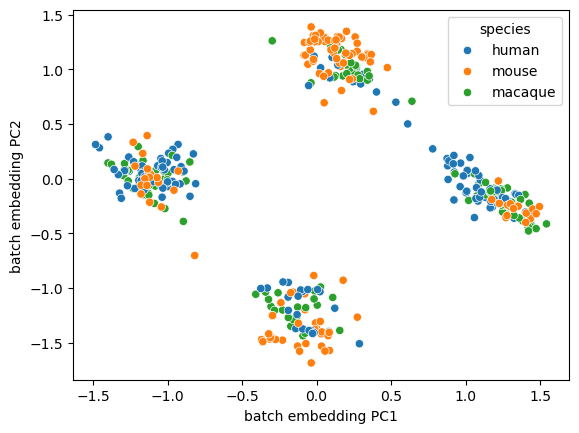

In [9]:
# plot_loss(antipode_model.losses)
plot_gmm_heatmaps(antipode_model)
plot_d_hists(antipode_model)
plot_batch_embedding_pca(antipode_model)

In [10]:
pstore=adata.uns['param_store']
discov_cluster_params,cluster_params, cluster_labels,var_labels,(prop_taxon, prop_locs,prop_discov_di,prop_discov_dm)=antipode_model.calculate_cluster_params(flavor='numpy')
cluster_index = np.array([int(x) for x in cluster_labels])
discov_cluster_params = discov_cluster_params[:,cluster_index,:]
discov_labels=adata.obs[antipode_model.discov_key].cat.categories
latent_labels=[str(x) for x in range(pstore['discov_dc'].shape[1])]
n_clusters=antipode_model.level_sizes[-1]

In [11]:
aggr_means=antipode.model_functions.group_aggr_anndata(adata,['species','level_2'],layer=layer_key,normalize=True)
log_real_means=antipode.model_functions.safe_log_transform(aggr_means[0]) # #species,#cluster,#genes array

100%|██████████| 678/678 [01:18<00:00,  8.67it/s]


In [12]:
real_means=pd.DataFrame(log_real_means.mean(0),columns=adata.var.index,index=aggr_means[1]['level_2'])
real_means=real_means.loc[aggr_means[1]['level_2'],:]

In [14]:
fits=[]
for i in range(discov_cluster_params.shape[0]):
    for g in range(discov_cluster_params.shape[2]):
        x=discov_cluster_params[i,:,g]
        y=log_real_means[i,:,g]
        fits.append(scipy.stats.stats.spearmanr(x,y).statistic)


/scratch/fast/4767/ipykernel_3045775/2048301033.py:6: DeprecationWarning: Please import `spearmanr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  fits.append(scipy.stats.stats.spearmanr(x,y).statistic)
/scratch/fast/4767/ipykernel_3045775/2048301033.py:6: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  fits.append(scipy.stats.stats.spearmanr(x,y).statistic)


0.763129204279289


Text(0.5, 1.0, '')

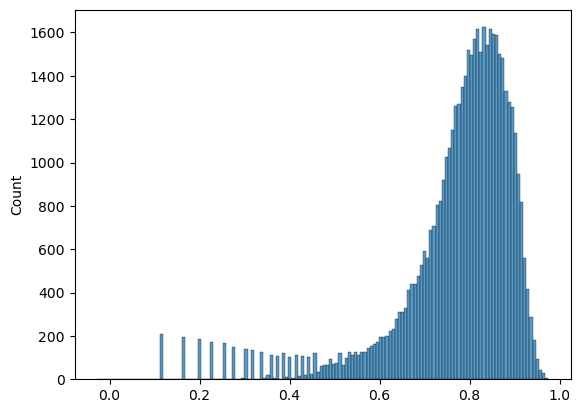

In [15]:
print(np.mean(np.nan_to_num(fits)))
seaborn.histplot(fits)
plt.title('')

Text(0, 0.5, 'actual gene log mean')

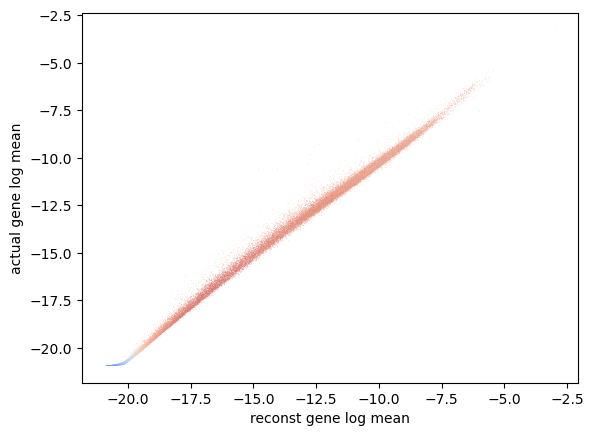

In [16]:
cmap = plt.cm.coolwarm

# Map 'fits' values to the colormap
colors = cmap(np.array(fits))
seaborn.scatterplot(x=discov_cluster_params.mean(1).flatten(),y=log_real_means.mean(1).flatten(),s=0.1,color=colors)
plt.xlabel('reconst gene log mean')
plt.ylabel('actual gene log mean')

In [17]:
print(cluster_index)
print(aggr_means[1]['level_2'])

[  1   2   3   4   5   6   7   8   9  10  11  12  14  15  16  17  19  21
  22  23  24  26  27  29  30  33  35  36  39  40  41  42  43  44  45  46
  47  48  49  50  51  52  53  54  56  57  58  59  62  63  64  68  71  72
  73  74  75  77  78  79  80  81  82  83  84  86  88  89  90  91  92  93
  95  97  98 100 101 102 105 106 107 108 109 110 111 113 114 115 116 117
 118 120 121 122 123 125 126 127 128 130 131 133 136 137 138 141 142 143
 144 145 146 147 148 150 151 153 154 155 156 157 158 159 163 164 165 167
 169 170 172 173 174 176 177 178 180 181 182 183 184 185 186 187 188 191
 192 193 195 196 197 199 200 201 203 204 205 206 207 208 209 210 212 215
 216 217 218 219 221 224 225 226 227 228 229 230 231 232 234 235 237 238
 239 240 241 242 244 247 249 250 251 252 253 254 256 257 258 259 261 262
 263 264 265 266 268 269 270 271 272 273 274 276 277 278 279 280 281 282
 284 285 290 292 293 294 295 296 297 299]
['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '14', '15', '16', 

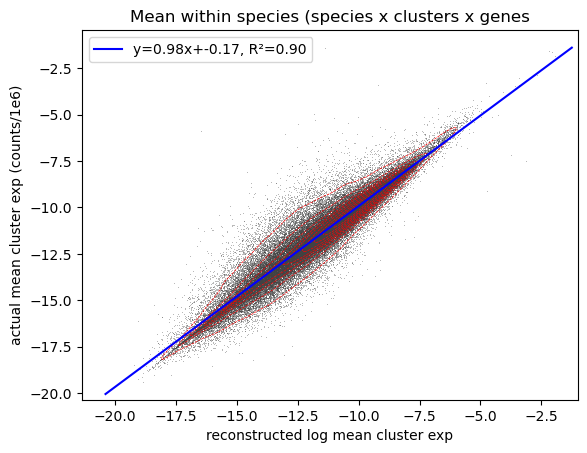

In [18]:
# Calculate the regression parameters
x=(discov_cluster_params).flatten()
x=safe_log_transform(np.exp(x))
y=log_real_means.flatten()
zeros=y>-20
x=x[zeros]
y=y[zeros]
randinds=np.random.choice(np.array(list(range(x.shape[0]))),size=100000,replace=False)


seaborn.scatterplot(x=x[randinds],y=y[randinds],s=0.2,color='black')
seaborn.kdeplot(x=x[randinds],y=y[randinds],linestyles='--',color='red', linewidths=0.5)
plt.xlabel('reconstructed log mean cluster exp')
plt.ylabel('actual mean cluster exp (counts/1e6)')


slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x,y)

# Plot the regression line
x_values = np.linspace(np.min(x), np.max(x), 100)
plt.plot(x_values, slope * x_values + intercept, color='blue', label=f'y={slope:.2f}x+{intercept:.2f}, R²={r_value**2:.2f}')
plt.title('Mean within species (species x clusters x genes')
# Add legend
plt.legend()

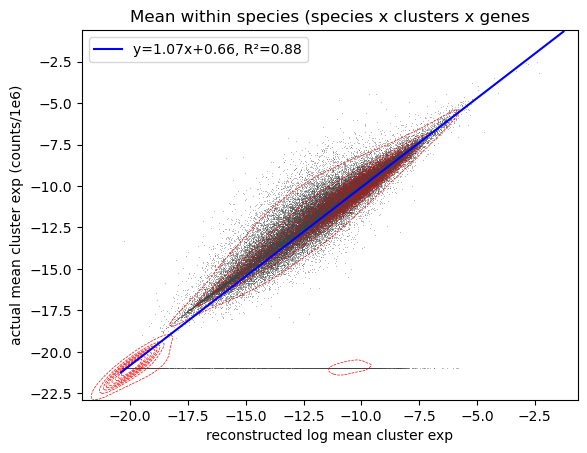

In [19]:
# Calculate the regression parameters
x=(discov_cluster_params).flatten()
x=safe_log_transform(np.exp(x))
y=log_real_means.flatten()
randinds=np.random.choice(np.array(list(range(x.shape[0]))),size=100000,replace=False)


seaborn.scatterplot(x=x[randinds],y=y[randinds],s=0.2,color='black')
seaborn.kdeplot(x=x[randinds],y=y[randinds],linestyles='--',color='red', linewidths=0.5)
plt.xlabel('reconstructed log mean cluster exp')
plt.ylabel('actual mean cluster exp (counts/1e6)')


slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x,y)

# Plot the regression line
x_values = np.linspace(np.min(x), np.max(x), 100)
plt.plot(x_values, slope * x_values + intercept, color='blue', label=f'y={slope:.2f}x+{intercept:.2f}, R²={r_value**2:.2f}')
plt.title('Mean within species (species x clusters x genes')
# Add legend
plt.legend()

In [20]:
antipode_model.save(os.path.join('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/models',model_tag),save_anndata=True,prefix='p4_')